In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

In [38]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda


In [39]:
image_size = 32
data_dir = './trafic_32/'
batch_size = 64
val_split = 0.1

In [40]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
total_size = len(dataset)
val_size = int(total_size * val_split)
train_size = total_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Loadery
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [41]:
print(dataset[1])
print(dataset[0][0].shape)

(tensor([[[-0.4275, -0.3804, -0.4039,  ..., -0.4353, -0.3882, -0.4824],
         [-0.5294, -0.4588, -0.3176,  ..., -0.3176, -0.4118, -0.4275],
         [-0.5451, -0.4588, -0.3176,  ..., -0.1843, -0.3647, -0.4667],
         ...,
         [ 0.2314,  0.2235,  0.0902,  ..., -0.3804, -0.3333, -0.2314],
         [-0.1373, -0.1608, -0.1765,  ..., -0.4039, -0.2706, -0.2000],
         [-0.4275, -0.3412, -0.2157,  ..., -0.4510, -0.2627, -0.2471]],

        [[-0.4196, -0.3725, -0.4196,  ..., -0.4275, -0.3725, -0.4667],
         [-0.4824, -0.4431, -0.3255,  ..., -0.3569, -0.4275, -0.4275],
         [-0.4431, -0.3961, -0.3490,  ..., -0.3412, -0.4510, -0.5137],
         ...,
         [ 0.0118,  0.0667,  0.0431,  ..., -0.3647, -0.3647, -0.2784],
         [-0.2157, -0.2392, -0.2706,  ..., -0.3255, -0.2157, -0.1373],
         [-0.4275, -0.3725, -0.3333,  ..., -0.3647, -0.1529, -0.1373]],

        [[-0.4039, -0.3569, -0.3961,  ..., -0.3882, -0.3804, -0.4902],
         [-0.4980, -0.4667, -0.3412,  ..., -

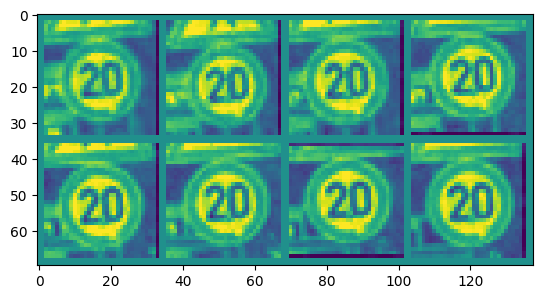

In [42]:
def get_train_images(num):
    return torch.stack([dataset[i][0] for i in range(10,10+num)], dim=0)

plt.imshow(torchvision.utils.make_grid(get_train_images(8), nrow=4)[0]);

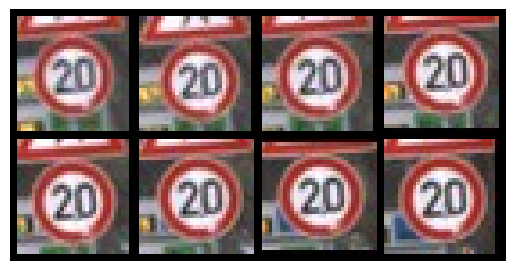

In [43]:
import torch
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def get_train_images(num):
    # Pobierz obrazy z datasetu
    images = torch.stack([dataset[i][0] for i in range(10, 10 + num)], dim=0)
    # Odwróć normalizację: (x * std) + mean
    images = images * 0.5 + 0.5  # dla mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
    return images

# Pobierz obrazy
images = get_train_images(8)

# Utwórz siatkę obrazów
grid = vutils.make_grid(images, nrow=4, padding=2, normalize=False)

# Zamień osie z (C, H, W) na (H, W, C) dla matplotlib
grid = grid.permute(1, 2, 0)

# Wyświetl obrazy
plt.imshow(grid)
plt.axis('off')
plt.show()

In [44]:
def corrupt(x, amount):
    noise = torch.randn_like(x)  # Gaussian noise
    amount = amount.view(-1, 1, 1, 1)
    # Blend original and noise, keeping range compatible with [-1, 1]
    noisy_x = x * (1 - amount) + noise * amount
    return noisy_x.clamp(-1, 1)  # Ensure output stays in [-1, 1]

Input shape: torch.Size([43, 3, 32, 32])


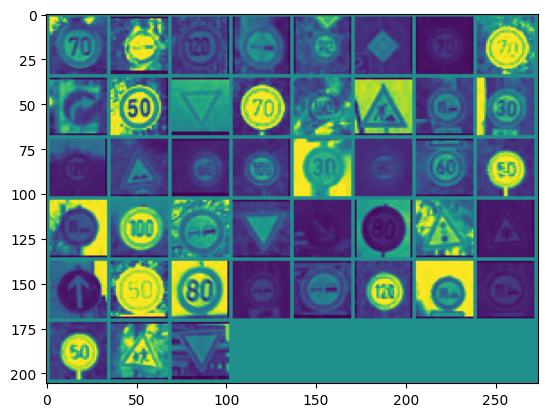

In [45]:
x, y = next(iter(train_loader))
x = x[:43]
print('Input shape:', x.shape)
plt.imshow(torchvision.utils.make_grid(x)[0]);

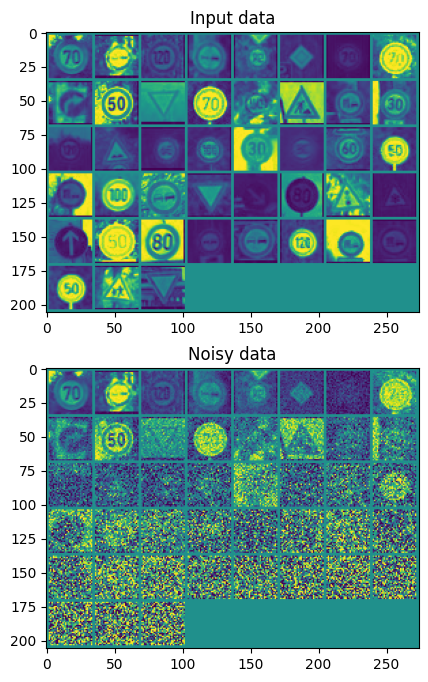

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0])

amount = torch.linspace(0, 1, x.shape[0])
noised_x = corrupt(x, amount)

axs[1].set_title('Noisy data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0]);

In [53]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb 

class BasicUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, time_dim=128, num_classes=43):
        super().__init__()
        self.time_embed = nn.Sequential(
            SinusoidalTimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        self.label_embed = nn.Embedding(num_classes, time_dim)

        self.down_layers = nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
        ])

        self.up_layers = nn.ModuleList([
            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
        ])

        self.time_y_proj = nn.Linear(time_dim, 128)

        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x, y, t):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:
                h.append(x)
                x = self.downscale(x)

        t_emb = self.time_embed(t)
        y_emb = self.label_embed(y)
        cond = t_emb + y_emb         
        cond_proj = self.time_y_proj(cond).view(x.shape[0], -1, 1, 1)
        x = x + cond_proj

        for i, l in enumerate(self.up_layers):
            if i > 1:
                x = self.upscale(x)
                skip = h.pop()
                skip = self.skip_projections[i-2](skip)  # Project skip connection
                x = x + skip
            x = self.act(l(x))
        return x


In [54]:
net = BasicUNet().to(device)
net

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [306]:
net = UNet32()
net

UNet32(
  (down1): DownBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down2): DownBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, pa

In [31]:
def tensor_to_image(tensor, normalize=True):
    tensor = tensor.cpu().detach()
    print(f"Tensor min: {tensor.min().item():.4f}, max: {tensor.max().item():.4f}")
    if normalize:
        tensor = (tensor + 1) / 2
        tensor = tensor.clamp(0, 1)
    tensor = tensor.permute(1, 2, 0)
    return tensor.numpy()

In [32]:
n_epochs = 20

net = BasicUNet()
net.to(device)

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=1e-4)

losses = []

for epoch in range(n_epochs):

    for x, y in tqdm(train_loader):
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)

        pred = net(noisy_x, y, noise_amount)

        loss = loss_fn(pred, x)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-len(loader):])/len(loader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

    with torch.no_grad():
        num_samples = min(3, x.shape[0])  # Visualize up to 3 images
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
        if num_samples == 1:
            axes = [axes]  # Make axes iterable for single sample

        for i in range(num_samples):
            original = x[i]  # Original image
            noisy = noisy_x[i]  # Noisy image
            generated = pred[i]  # Model's denoised output

            # Convert tensors to images
            print(f"Sample {i+1}:")
            original_img = tensor_to_image(original, normalize=True)
            noisy_img = tensor_to_image(noisy, normalize=True)
            generated_img = tensor_to_image(generated, normalize=True)

            # Plot original
            axes[i][0].imshow(original_img)
            axes[i][0].set_title('Original Image')
            axes[i][0].axis('off')

            # Plot noisy
            axes[i][1].imshow(noisy_img)
            axes[i][1].set_title('Noisy Image')
            axes[i][1].axis('off')

            # Plot generated
            axes[i][2].imshow(generated_img)
            axes[i][2].set_title('Generated (Denoised) Image')
            axes[i][2].axis('off')

        plt.suptitle(f'Epoch {epoch}')
        plt.tight_layout()
        plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plt.plot(losses)
plt.ylim(0, 0.5);

In [ ]:
import torch
import torchvision.transforms as T
from torchmetrics.image.fid import FrechetInceptionDistance
from tqdm import tqdm

# Inicjalizacja FID
fid = FrechetInceptionDistance(feature=2048, normalize=True).to(device)

# Resize do 299x299 i normalizacja do [-1, 1] → wymagane przez Inception
transform = T.Compose([
    T.Resize((299, 299)),
    T.Normalize((0.5,), (0.5,)) if x.shape[1] == 1 else T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Zbieranie obrazów z walidacji lub testu
net.eval()
with torch.no_grad():
    for x, y in tqdm(val_loader):  # Upewnij się, że val_loader jest zdefiniowany
        x = x.to(device)
        y = y.to(device)
        noise_amount = torch.rand(x.shape[0]).to(device) * 0.3
        noisy_x = corrupt(x, noise_amount)
        pred = net(noisy_x, y, noise_amount)

        for real_img, gen_img in zip(x, pred):
            real_img = transform(real_img).unsqueeze(0)
            gen_img = transform(gen_img).unsqueeze(0)
            fid.update(real_img, real=True)
            fid.update(gen_img, real=False)

fid_score = fid.compute()
print(f"FID score: {fid_score.item():.4f}")
